In [1]:
cd ..

/home/ubuntu/superduperdb


In [2]:
from superduperdb.mongodb.client import SuperDuperClient
from IPython.display import display, Image as I
import json

c = SuperDuperClient()
docs = c.ecommerce.documents

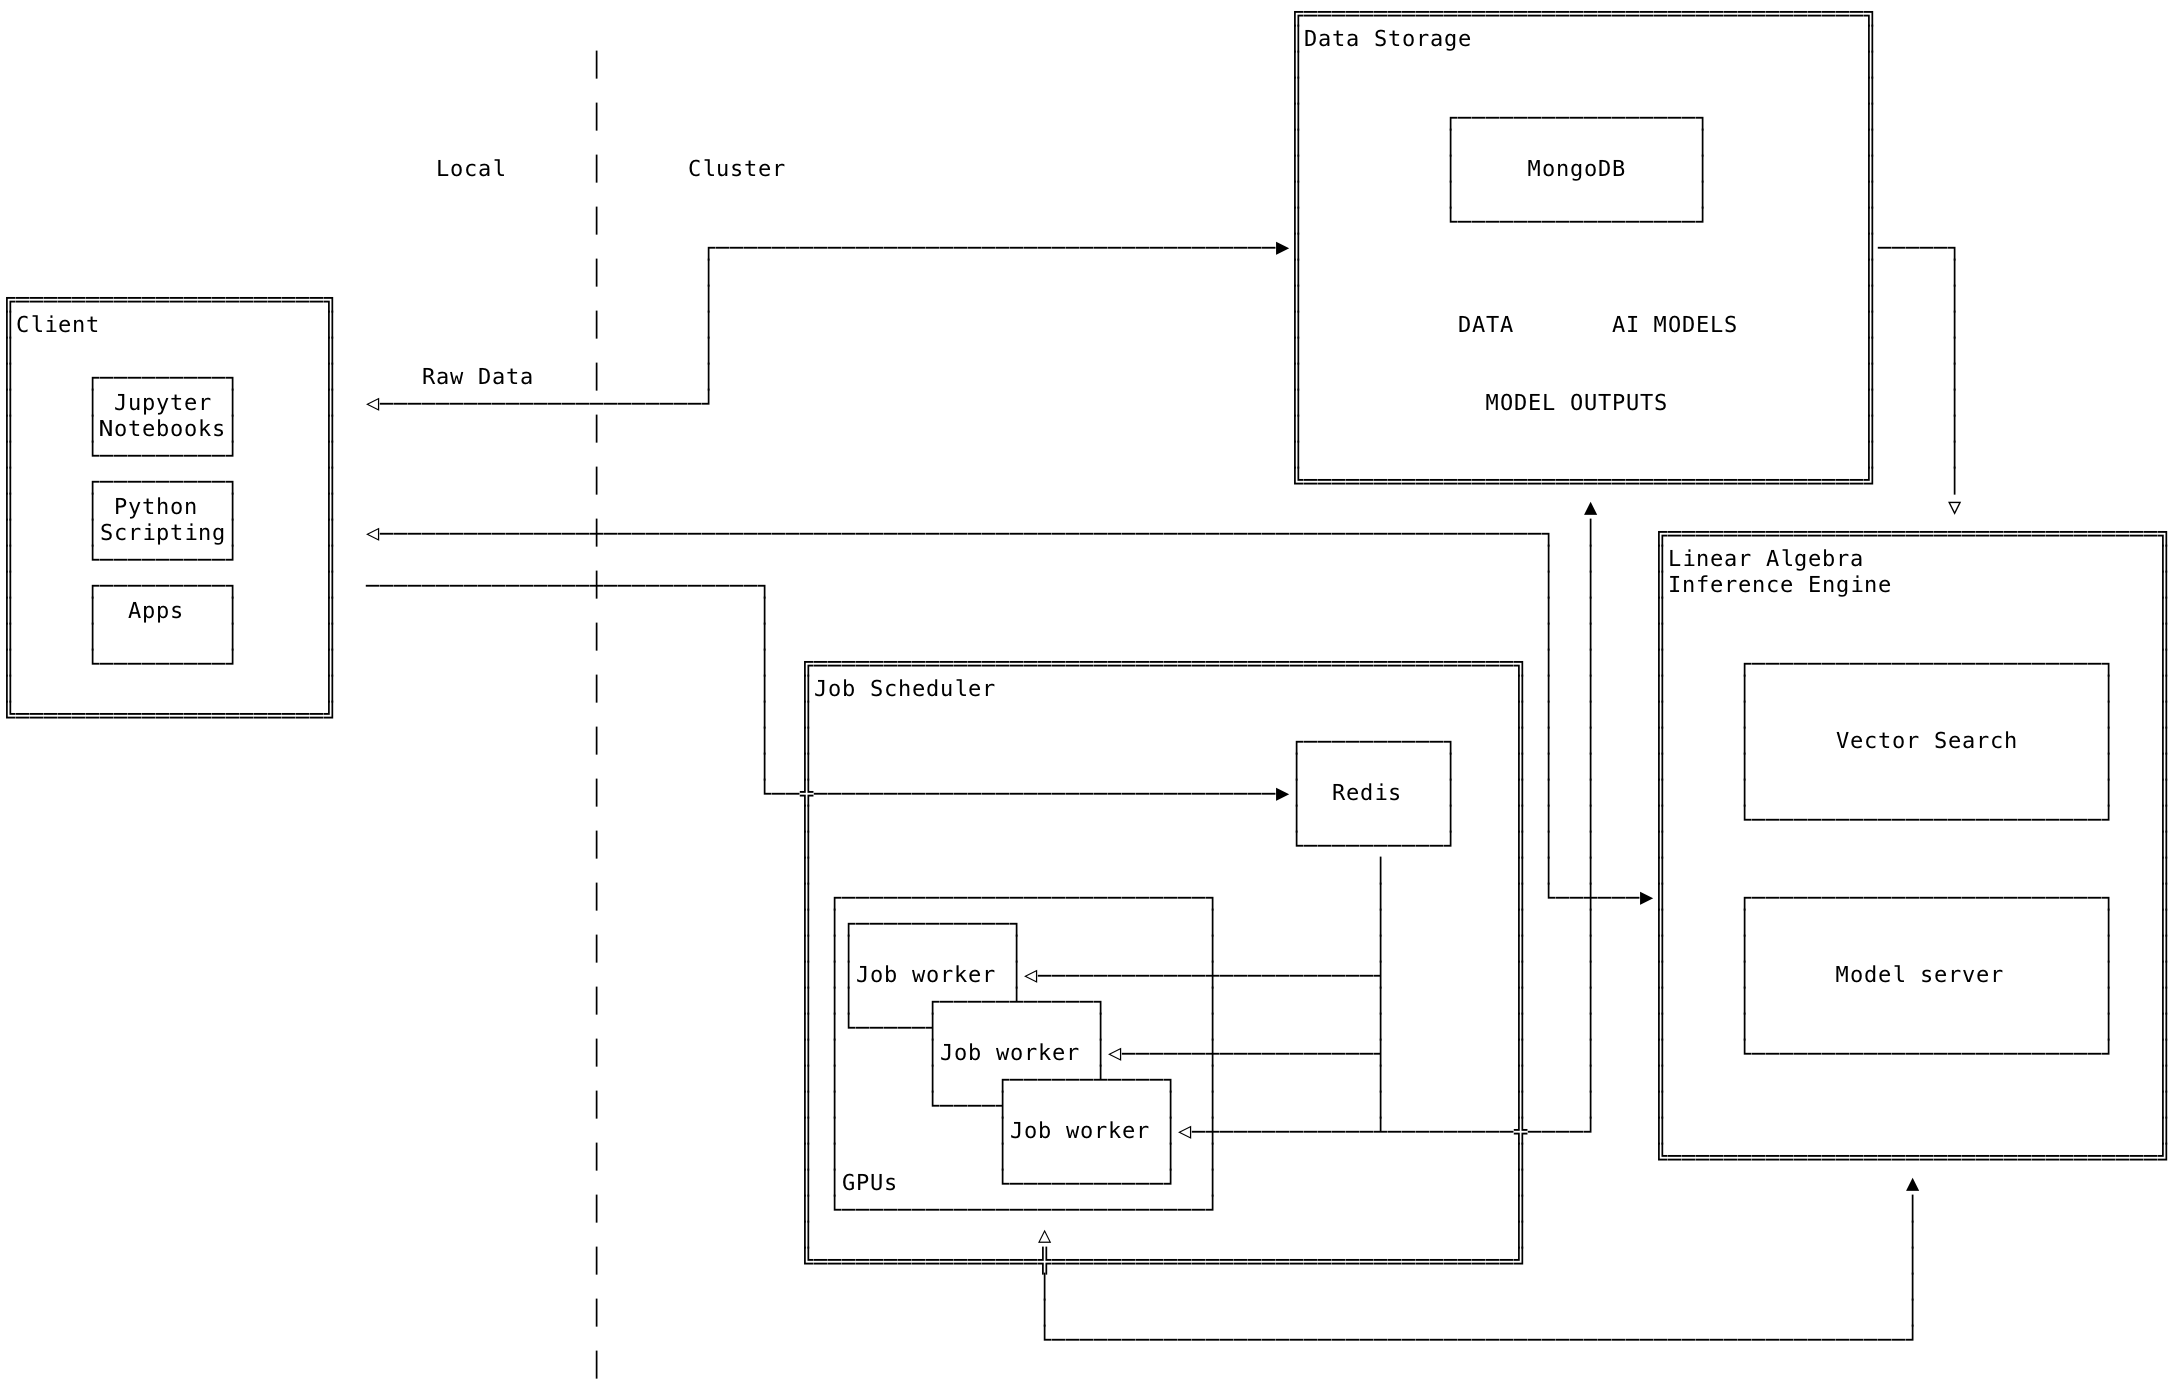

In [3]:
I('docs/img/architecture_now.png')

In [4]:
with open('/data/ecommerce.json') as f:
    data = json.load(f)

In [5]:
data[:3]

[{'i': 0,
  'brand': 'Even&Odd',
  'title': 'BODYSUIT - Long sleeved top',
  'img': {'_content': {'url': 'file:///data/img/0.jpg', 'type': 'image'}},
  '_fold': 'train'},
 {'i': 2,
  'brand': 'Reebok',
  'title': 'LEGGING - Leggings',
  'img': {'_content': {'url': 'file:///data/img/2.jpg', 'type': 'image'}},
  '_fold': 'valid'},
 {'i': 3,
  'brand': 'Under Armour',
  'title': 'Hoodie',
  'img': {'_content': {'url': 'file:///data/img/3.jpg', 'type': 'image'}},
  '_fold': 'train'}]

In [6]:
_, jobs = docs.insert_many(data)
jobs

defaultdict(<function superduperdb.database.BaseDatabase._process_documents.<locals>.<lambda>()>,
            {'_download_content': ['5254fd61-2994-4fa6-9b65-a30f7b2c8c5b']})

In [7]:
docs.watch_job(jobs['_download_content'][0])

found 30989 urls
number of workers 0
100%|##########| 30989/30989 [00:44<00:00, 703.85it/s]


In [8]:
import io
import numpy
import PIL.Image
import PIL.JpegImagePlugin, PIL.PngImagePlugin
import torch


class PILImage:
    types = (PIL.JpegImagePlugin.JpegImageFile, PIL.PngImagePlugin.PngImageFile)
    
    @staticmethod
    def encode(x):
        buffer = io.BytesIO()
        x.save(buffer, format='png')
        return buffer.getvalue()

    @staticmethod
    def decode(bytes_):
        return PIL.Image.open(io.BytesIO(bytes_))


class FloatTensor:
    types = (torch.FloatTensor, torch.Tensor)

    @staticmethod
    def encode(x):
        x = x.to('cpu').numpy()
        assert x.dtype == numpy.float32
        return memoryview(x).tobytes()

    @staticmethod
    def decode(bytes_):
        array = numpy.frombuffer(bytes_, dtype=numpy.float32)
        return torch.from_numpy(array).type(torch.float)
    
docs.create_type('float_tensor', FloatTensor, serializer='dill')
docs.create_type('image', PILImage(), serializer='dill')

In [9]:
docs.list_types()

['float_tensor', 'image']

In [10]:
docs.find_one(raw=True)

{'_id': ObjectId('643d2b4c3fd24df6814ee6c7'),
 'i': 0,
 'brand': 'Even&Odd',
 'title': 'BODYSUIT - Long sleeved top',
 'img': {'_content': {'url': 'file:///data/img/0.jpg',
   'type': 'image',
   'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xfa\x00\x00\x01i\x08\x02\x00\x00\x00:\x0b\xa23\x00\x00\xa5`IDATx\x9c\xec\xfdy\x94\x9d\xc9u\x1f\x08\xde{#\xe2[\xde\x96{b\x07\n\xb5\x93U\xa4\x8a\xfb.\x8a\x14\x17\x93\x96\xe93\xb6\xd8V\xd3\xb2}\x8e\xdd#\x8f=\x1e\xb5\xc73\xe3\xe9\xe3q\xabg\xdcs<\xedcK\xdd\x1aiDY\x94\x17\xb5d\x89\x92E\xb5\xac\x85\x12%\x8a\xab\xc4\xe2*\x96\xc8bm(T\x01(\x14\x96\xdc\xdf\xf6m\x11q\xef\xfc\x11\xef=<\xe4\x82J\x00\t \x13\xc0\xef\xe4\xc9\xf3\xf2\xcb\xef}\xeb/n\xdc\xb8+>\xf1\xc4\x13p5@\xc4M\xb7\x8b\xc8+\xee\xb3\x9d\xe3\xec\xd4y\xc7\xb7_\xcfy\xaf\xf6znWl\xf5<o\xf4q\xb6\xf3\xde\xb7\x0f}\r\xdf\xb92v\t\x0fv\xc9e\xdc\xc5:\xdc\xda\xf7B;{\xb8\xbb$\xbb\x8b\xdd\x8c\x1d\x93\xee\x1b\x89\x1e\xb6\xec\xd4$x\xa3qw\xa0^\x19;\xf5|n-\x1fv^\x99\t\xb8c\xd9s\xabn\xfcj\xd7*{E\x0cm\x85k\x

In [11]:
docs.find_one()

{'_id': ObjectId('643d2b4c3fd24df6814ee6c7'),
 'i': 0,
 'brand': 'Even&Odd',
 'title': 'BODYSUIT - Long sleeved top',
 'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=250x361>,
 '_fold': 'train'}

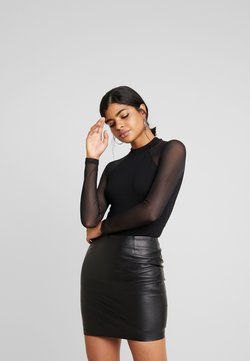

In [12]:
docs.find_one()['img']

In [19]:
import torch
from clip import load, tokenize


class Image(torch.nn.Module):
    def __init__(self, model, preprocess):
        super().__init__()
        self.model = model
        self.preprocess = preprocess

    def forward(self, x):
        return self.model.encode_image(x)


class Text(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model.encode_text(x)

    def preprocess(self, x):
        return tokenize(x)[0]
    


class CLIP(torch.nn.Module):
    def __init__(self, name):
        super().__init__()
        model, preprocess = load(name)
        self.image = Image(model, preprocess)
        self.text = Text(model)

    def preprocess(self, r):
        out = {}
        if "brand" in r or "title" in r:
            out["text"] = self.text.preprocess(f'{r.get("brand", "")} {r.get("title", "")}')
        if "img" in r:
            out["image"] = self.image.preprocess(r['img'])
        assert out
        return out

    def forward(self, r):
        assert r
        key = next(iter(r.keys()))
        bs = r[key].shape[0]
        out = torch.zeros(bs, 1024).to(r[key].device)
        n = 0
        if 'image' in r:
            tmp = self.image.forward(r['image'])
            tmp = tmp.div(tmp.pow(2).sum(axis=1).sqrt()[:, None])
            out += tmp
            n += 1
        if 'text' in r:
            tmp = self.text.forward(r['text'])
            tmp = tmp.div(tmp.pow(2).sum(axis=1).sqrt()[:, None])
            out += tmp
            n += 1
        return out / n

    
docs.create_model('clip', CLIP('RN50'), serializer='dill', type='float_tensor')

In [22]:
docs.list_models()

['clip']

In [14]:
def dot(x, y):
    return x.matmul(y.T)


def css(x, y):
    x = x.div(x.norm(dim=1)[:, None])
    y = y.div(y.norm(dim=1)[:, None])
    return dot(x, y)

docs.create_measure('css', css, serializer='dill')

In [15]:
docs.list_measures()

['css']

In [23]:
job_ids = docs.create_semantic_index(
    'clip', ['clip'], ['_base'], 'css', loader_kwargs={'batch_size': 100, 'num_workers': 8},
    verbose=True,
)

In [24]:
docs.watch_job(job_ids[0])

computing chunk (1/7)
finding documents under filter
done.
processing with clip
100%|##########| 50/50 [00:09<00:00,  5.27it/s]
done.
computing chunk (2/7)
finding documents under filter
done.
processing with clip
100%|##########| 50/50 [00:08<00:00,  5.74it/s]
done.
computing chunk (3/7)
finding documents under filter
done.
processing with clip
100%|##########| 50/50 [00:08<00:00,  5.99it/s]
bulk writing...
done.
computing chunk (4/7)
finding documents under filter
done.
processing with clip
100%|##########| 50/50 [00:08<00:00,  5.95it/s]
bulk writing...
done.
computing chunk (5/7)
finding documents under filter
done.
processing with clip
100%|##########| 50/50 [00:08<00:00,  5.87it/s]
bulk writing...
done.
computing chunk (6/7)
finding documents under filter
done.
processing with clip
100%|##########| 50/50 [00:08<00:00,  6.05it/s]bulk writing...

done.
computing chunk (7/7)
finding documents under filter
done.
processing with clip
100%|##########| 10/10 [00:02<00:00,  3.42it/s]
bulk

In [ ]:
!nvidia-smi

anchor image:


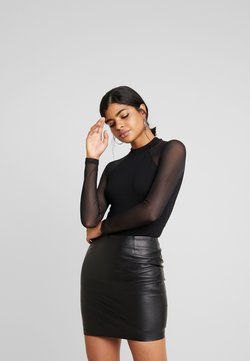

0.9999998211860657


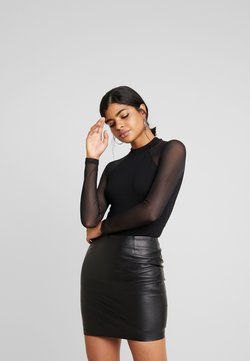

0.9040560722351074


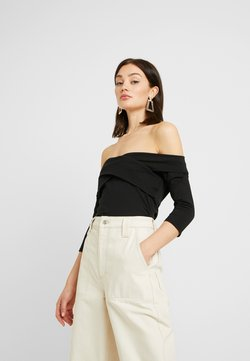

0.8707236647605896


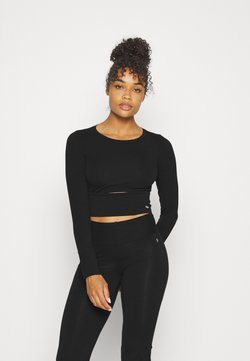

0.8674948811531067


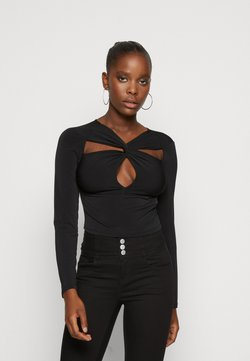

0.8622723817825317


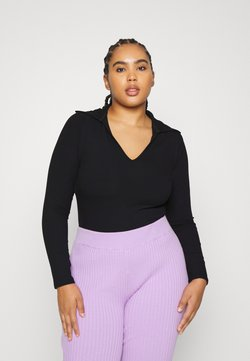

0.858154296875


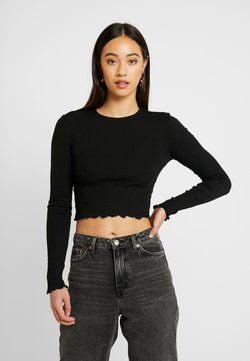

0.854727029800415


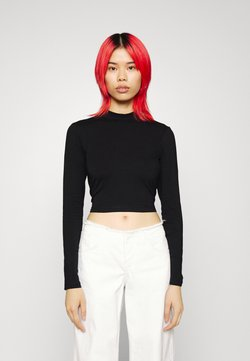

0.8531002998352051


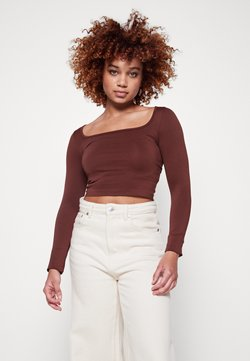

0.8525278568267822


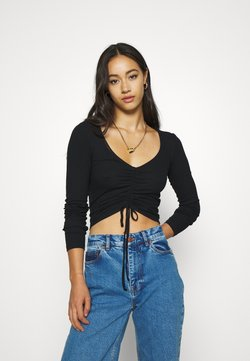

0.8514588475227356


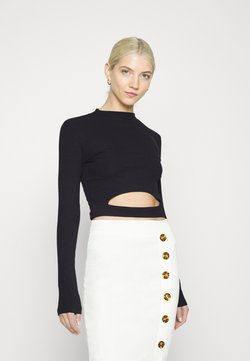

In [25]:
r = docs.find_one()

print('anchor image:')
display(r['img'])

for r in docs.find(like={'_id': r['_id']}, semantic_index='clip'):
    print(r['_score'])
    display(r['img'])

0.6066538095474243


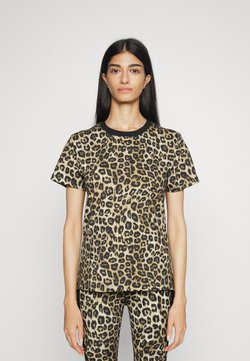

0.5866190791130066


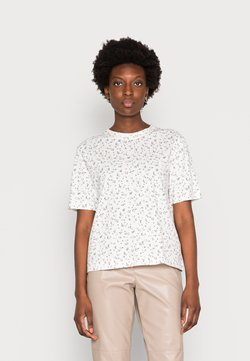

0.5834293365478516


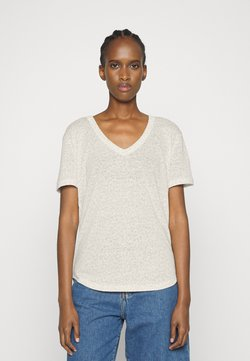

0.5762441754341125


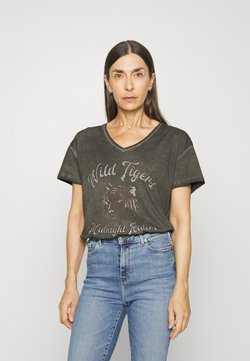

0.5744845271110535


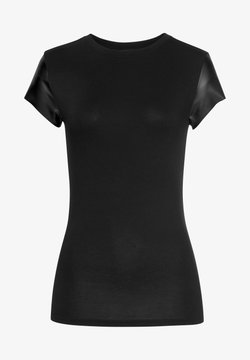

0.5740499496459961


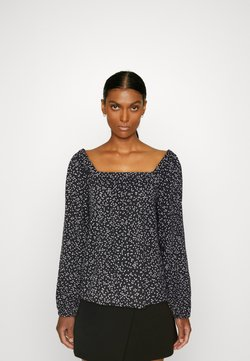

0.5720062255859375


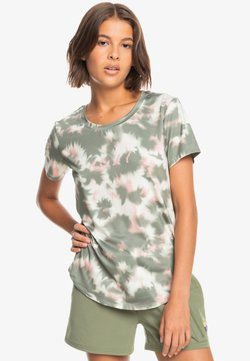

0.5711781978607178


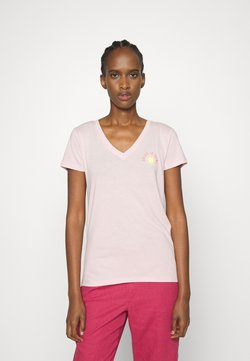

0.5703983902931213


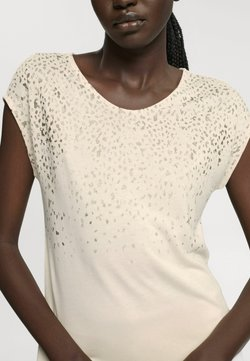

0.5690529346466064


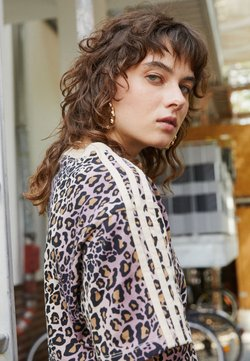

In [27]:
for r in docs.find(like={'title': 'leopard print t-shirt'}, semantic_index='clip'):
    print(r['_score'])
    display(r['img'])

number of workers 0


100%|██████████| 1/1 [00:00<00:00,  9.47it/s]


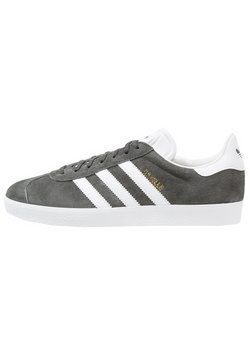

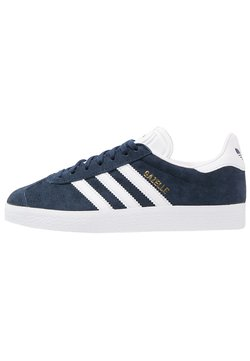

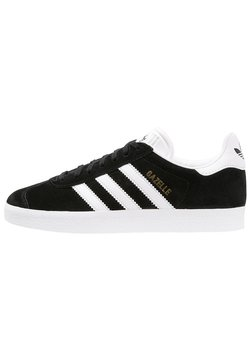

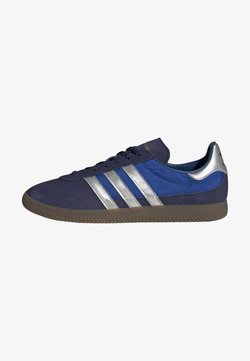

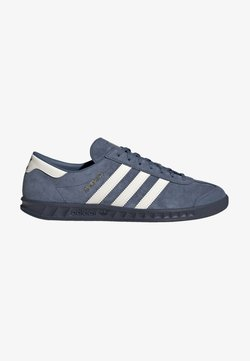

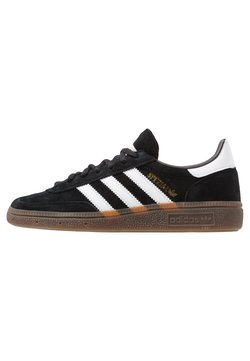

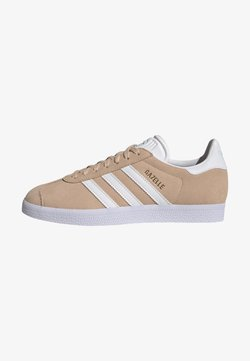

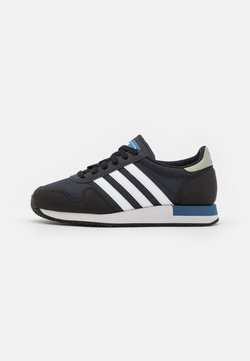

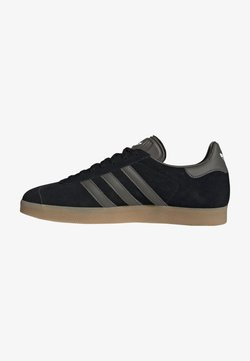

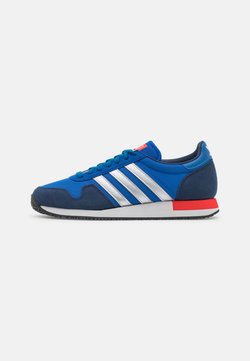

In [26]:
from IPython.display import Image as I

url = 'https://thumblr.uniid.it/product/238107/09ef5396fac2.jpg'
docs.remote = True

display(I(url=url, width=200))

cur = docs.find(like={'img': {'_content': {'url': url, 'type': 'image'}}}, semantic_index='clip', download=True)
for r in cur:
    display(r['img'])

In [28]:
import torch
from clip import load, tokenize


class ClassifierSimple(torch.nn.Module):
    def __init__(self, categories, name):
        super().__init__()
        self.categories = categories
        model, _ = load(name, device='cpu')
        category_vectors = \
            model.encode_text(torch.cat([tokenize(x) for x in categories], 0))
        category_vectors = category_vectors / category_vectors.norm(dim=1, keepdim=True)
        logit_scale = model.logit_scale.exp()
        self.register_buffer('category_vectors', category_vectors)
        self.register_buffer('logit_scale', logit_scale)
        
    @property
    def device(self):
        return self.category_vectors.device

    def preprocess(self, x):
        if isinstance(x, dict):
            x = x['_outputs']['_base']['clip']
        else:
            assert isinstance(x, torch.Tensor)
        return x

    def forward(self, x):
        x = x / x.norm(dim=1, keepdim=True)
        logits_per_image = self.logit_scale * x @ self.category_vectors.t()
        out = logits_per_image.softmax(dim=-1)
        return out

    def postprocess(self, x):
        pos = x.topk(1)[1].item()
        return self.categories[pos]

In [29]:
docs.create_model(
    'silhouettes', 
    ClassifierSimple(
        name='RN50',
        categories=[
            'accessory',
            'blouse',
            'coat',
            'dress',
            'hat',
            'hoodie',
            'jacket',
            'pullover',
            'shoes',
            'skirt',
            't-shirt',
            'trousers',
        ]
    ),
    serializer='dill',
)

BODYSUIT - Long sleeved top


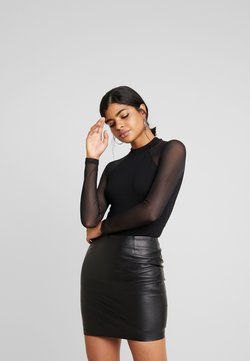

'blouse'

In [30]:
r = docs.find_one()
print(r['title'])
display(r['img'])
docs.apply_model('silhouettes', r)

In [31]:
job_id = docs.create_watcher(
    'silhouettes',
    features={'_base': 'clip'},
    loader_kwargs={'batch_size': 10, 'num_workers': 0},
    verbose=True,
)

In [32]:
docs.watch_job(job_id)

computing chunk (1/7)
finding documents under filter
done.
processing with silhouettes
100%|##########| 500/500 [00:00<00:00, 545.28it/s]
done.
computing chunk (2/7)
finding documents under filter
done.
processing with silhouettes
100%|##########| 500/500 [00:00<00:00, 1387.47it/s]
done.
computing chunk (3/7)
finding documents under filter
done.
processing with silhouettes
100%|##########| 500/500 [00:00<00:00, 1450.72it/s]
done.
computing chunk (4/7)
finding documents under filter
done.
processing with silhouettes
100%|##########| 500/500 [00:00<00:00, 1452.67it/s]
done.
computing chunk (5/7)
finding documents under filter
done.
processing with silhouettes
100%|##########| 500/500 [00:00<00:00, 1430.13it/s]
done.
computing chunk (6/7)
finding documents under filter
done.
processing with silhouettes
100%|##########| 500/500 [00:00<00:00, 1382.82it/s]
done.
computing chunk (7/7)
finding documents under filter
done.
processing with silhouettes
bulk writing...
100%|##########| 99/99 [00:0

In [33]:
list(docs.find().limit(3))

[{'_id': ObjectId('643d2b4c3fd24df6814ee6c7'),
  'i': 0,
  'brand': 'Even&Odd',
  'title': 'BODYSUIT - Long sleeved top',
  'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=250x361>,
  '_fold': 'train',
  '_outputs': {'_base': {'clip': tensor([ 0.0063,  0.0054, -0.0140,  ...,  0.0121,  0.0083, -0.0253]),
    'silhouettes': 'blouse'}}},
 {'_id': ObjectId('643d2b4c3fd24df6814ee6c8'),
  'i': 2,
  'brand': 'Reebok',
  'title': 'LEGGING - Leggings',
  'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=250x361>,
  '_fold': 'valid',
  '_outputs': {'_base': {'clip': tensor([ 0.0126, -0.0174, -0.0051,  ..., -0.0064, -0.0108, -0.0664]),
    'silhouettes': 'trousers'}}},
 {'_id': ObjectId('643d2b4c3fd24df6814ee6c9'),
  'i': 3,
  'brand': 'Under Armour',
  'title': 'Hoodie',
  'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=250x360>,
  '_fold': 'train',
  '_outputs': {'_base': {'clip': tensor([-0.0217, -0.0220, -0.0164,  ...,  0.0055, -0.0158, -0.0315]),
    'silhou